In [1]:
import random
import numpy as np
import pandas as pd
from scipy import stats
import matplotlib.pyplot as plt

In [2]:
class Client:
    """
    Class implementing a Client
    """
    def __init__(self, uId, type, arrival_time) -> None:
        self.uId = uId
        self.type = type
        self.arrival_time = arrival_time
        self.sId = -1

    def setServerId(self, sId):
        self.sId = sId

    def getType(self):
        return self.type

    def getArrivalTime(self):
        return self.arrival_time

    def getId(self):
        return self.uId

    def getServerId(self):
        return self.sId

In [3]:
class Server:
    """
    Class implementing a server
    """
    def __init__(self, s_Id) -> None:
        self.s_Id = s_Id
        self.client_served = -1
        self.departureTime = -1

    def get_client_served(self):
        return self.client_served

    def getId(self):
        return self.s_Id

    def removeClient(self):
        self.client_served = -1
        self.departureTime = -1

    def addClient(self, c):
        self.client_served = c

    def isEmpty(self):
        if self.client_served == -1:
            return True
        else:
            return False

    def setDepartureTime(self, departureTime):
        self.departureTime = departureTime

    def getDepartureTime(self):
        return self.departureTime

    def getClientType(self):
        return self.client_served.getType()

In [4]:
class Hyperexp(stats.rv_continuous):
    """
    An HyperExponential Random Variable
    credits: https://github.com/pixki/redesestocasticas/blob/master/phasedist.py
    """

    def __init__(self, alpha=0.5, lambda1=1/95 * (-2 - np.sqrt(194)), lambda2=1/95 * (np.sqrt(194) - 2)):
        self.alpha = alpha
        self.lambda1 = lambda1
        self.lambda2 = lambda2

    def rvs(self, size=1):
        vsample = np.vectorize(self._single_sample)
        return np.fromfunction(vsample, (size,))

    def _single_sample(self, size):
        U1 = np.random.random()
        if U1 <= self.alpha:
            scale = self.lambda1
        else:
            scale = self.lambda2
        U2 = np.random.random()

        return -np.log(U2)/scale

    def pdf(self, x):
        a = self.alpha*self.lambda1*np.exp(self.lambda1*-x)
        b = (1-self.alpha)*self.lambda2*np.exp(self.lambda2*-x)
        return a + b

    def mean(self):
        return (self.alpha / self.lambda1) + ((1-self.alpha) / self.lambda2)

    def standard_dev(self):
        a = (self.alpha/(self.lambda1**2)) + ((1-self.alpha)/(self.lambda2**2))
        return np.sqrt(2*a + self.mean()**2)

    def cdf(self, x):
        a = self.alpha*(-np.exp(self.lambda1*-x))
        b = (1-self.alpha)*(-np.exp(self.lambda2*-x))
        return a + b + 1

    def CoV(self):
        a = np.sqrt(2*self.alpha/self.lambda1 + 2*(1-self.alpha)/self.lambda2 -
                    (self.alpha/self.lambda1 + (1-self.alpha)/self.lambda2)**2)
        return a/self.mean()

In [5]:
class PriorityQueue:
    """
    Class implementig a priority queue
    """
    def __init__(self, ARRIVAL, DEPARTURE, p_hp, p_lp, service_type, SIZE_LIMIT, nServers):
        """
        :param ARRIVAL: arrival rate (lambda of a poisson process)
        :param DEPARTURE: service rate
        :param p_hp: probability of having a high priority client
        :param p_lp: probability of having a low priority client
        :param service_type: specifies the service time distribution: can be "exp", "det", "hyper"
        :param SIZE_LIMIT: maximum size of the queue
        :param nServers: number of servers
        """
        self.ARRIVAL = ARRIVAL
        self.DEPARTURE = DEPARTURE
        self.p_hp = p_hp
        self.p_lp = p_lp
        self.service_type = service_type
        self.SIZE_LIMIT = SIZE_LIMIT

        self.u_Id = 0
        self.users = 0  # number of users
        self.queue = []
        self.FES = []

        self.columns = ['event', 'time', 'u_Id', 's_Id', 'type', 'event_type',
                        'queue', 'arr cust', 'depar cust', "in line"]
        self.columns_s = ['time', 'event_type', 'u_Id', 's_Id', 'type']
        self.columns_delay = ["delay", "u_Id", "type"]
        self.df = pd.DataFrame(columns=self.columns)
        self.df_s = pd.DataFrame(columns=self.columns_s)
        self.df_delay = pd.DataFrame(columns=self.columns_delay)
        self.delays = []

        self.servers = []  # server list
        self.nServers = nServers  # number of servers

    def add_to_df(self, l):
        self.df.loc[len(self.df)] = l

    def add_to_df_s(self, l):
        self.df_s.loc[len(self.df_s)] = l

    def add_to_df_delay(self, l):
        self.df_delay.loc[len(self.df_delay)] = l

    def selectServer(self):
        """
        Select the first empty server
        :return: sId if a server is empty, else -1
        """
        for s in self.servers:
            if s.isEmpty() is True:
                return s

        return -1

    def getIdleServers(self):
        """
        :return: number of idle servers
        """
        count = 0
        for s in self.servers:
            if s.isEmpty() is True:
                count += 1
        return count

    def setServers(self):
        """
        create servers
        """
        for sId in range(self.nServers):
            self.servers.append(Server(sId))

    def get_df(self):
        return self.df

    def get_df_s(self):
        return self.df_s

    def get_df_delay(self):
        return self.df_delay

    def findFirstLowPriorityClient(self):
        """
        Find the first low priority client in queue
        :return: the index of the first low priority client in the queue, if none return -1
        """
        for i in range(len(self.queue)):
            if self.queue[i].getType() == 0:
                return i

        return -1

    def arrival(self, time, FES, queue):
        # print("ARRIVAL at time: \t{}".format(time))

        # generate type
        type = np.random.choice([0, 1], p=[self.p_lp, self.p_hp])

        # create a record for the client
        client = Client(self.u_Id, type, time)
        self.u_Id += 1

        # sample time until next event
        #inter_arrival = random.expovariate(self.ARRIVAL)
        inter_arrival = stats.poisson.rvs(1/self.ARRIVAL)

        if self.SIZE_LIMIT > 0:
            if len(queue) > self.SIZE_LIMIT:
                self.u_Id -= 1
                FES.append((time + inter_arrival, -1, -1, -1, "skip"))
                return

        # schedule next arrival
        FES.append((time + inter_arrival, client.getId() + 1, -1, -1, "arrival"))
        # update state variables
        self.users += 1

        # print("new CLIENT [{}] created of type [{}] at time [{}]".format(client.getId(), client.getType(), client.getArrivalTime()))
        l = [client.getArrivalTime(), "arrival", client.getId(), -1, client.getType()]
        self.add_to_df_s(l)

        # insert record in the queue
        if type == 1:  # if the client is high priority skip line
            i = self.findFirstLowPriorityClient()
            if i == -1:  # no low priority client
                queue.append(client)
            else:
                queue.insert(i, client)  # high priority client before low priority ones
        else:
            queue.append(client)


        # if at least one server is idle start the service
        if self.getIdleServers() > 0:
            # select empty server
            server = self.selectServer()
            if server == -1:
                print("ERROR: no empty servers")
            sId = server.getId()

            # sample the service time
            if self.service_type == "exp":
                if client.getType() == 1:  # hp
                    service_time = random.expovariate(self.p_hp)
                else:
                    service_time = random.expovariate(self.p_lp)
            elif self.service_type == "det":
                if client.getType() == 1:  # hp
                    service_time = self.p_hp
                else:
                    service_time = self.p_lp
            elif self.service_type == "hyper":
                h = Hyperexp()  # mean=1, std=10
                service_time = h.rvs()
            else:
                print("ERROR!!")

            #print(time + service_time)
            FES.append((time + service_time, client.getId(), sId, type, "departure"))

            self.servers[sId].setDepartureTime(time + service_time)
            self.servers[sId].addClient(client)
            client.setServerId(sId)

    def departure(self, time, FES, queue):
        # get the first element from the queue
        client = queue.pop(0)

        # print("CLIENT {} of type [{}] created at time [{}] departed at time [{}]".format(client.getId(), client.getType(), client.getArrivalTime(), time))
        l = [time, "departure", client.getId(), client.getServerId(), client.getType()]
        self.add_to_df_s(l)
        l = [time - client.getArrivalTime(), client.getId(), client.getType()]
        self.add_to_df_delay(l)

        # update state variable
        self.users -= 1
        sId = client.getServerId()
        self.servers[sId].removeClient()

        # see weather there are more clients to serve in the line
        if len(queue) > self.getIdleServers():
            # sample the service time
            if self.service_type == "exp":
                if client.getType() == 1:  # hp
                    service_time = random.expovariate(self.p_hp)
                else:
                    service_time = random.expovariate(self.p_lp)
            elif self.service_type == "det":
                if client.getType() == 1:  # hp
                    service_time = self.p_hp
                else:
                    service_time = self.p_lp
            elif self.service_type == "hyper":
                h = Hyperexp()  # mean=1, std=10
                service_time = h.rvs()
            else:
                print("ERROR!!")

            client = queue[0]  # next client in line

            ###
            # if client.getType() == 1:
            #     FES.sort(key=lambda x: x[0])
            #     flag = 0
            #     for event, i in zip(FES, range(len(FES))):
            #         if flag == 1:
            #             FES[i] = (FES[i][0], FES[i][1] + time + service_time, FES[i][2], FES[i][3], FES[i][4])
            #         else:
            #             if event[3] == 1:
            #                 flag = 1
            #                 FES.insert(i, (time + service_time, client.getId(), sId, client.getType(), "departure"))
            # else:
            #     FES.append((time + service_time, client.getId(), sId, client.getType(), "departure"))
            ###

            # schedule when the client will finish the server
            # print(time + service_time)
            FES.append((time + service_time, client.getId(), sId, client.getType(), "departure"))

            self.servers[sId].setDepartureTime(time + service_time)
            self.servers[sId].addClient(client)
            client.setServerId(sId)

    def simulate(self):
        """
        simulate the priority queue
        """
        self.setServers()

        # simulation time
        time = 0

        # event counter
        event = 0
        arrivals = 0
        departures = 0

        # schedule the first arrival at t=0
        self.FES.append((time, self.u_Id, -1, -1, "arrival"))

        sim_time = 0
        while sim_time < 1000:
            # sort FES in order to ave events in cronological order
            self.FES.sort(key=lambda x: x[0])
            (time, Id, sId, type, event_type) = self.FES.pop(0)

            # if queue size is finite
            if event_type == "skip":
                self.arrival(time, self.FES, self.queue)

            elif event_type == "arrival":
                event += 1
                arrivals += 1

                l = [event, float(time), Id, sId, type, "arrival", len(self.queue), arrivals, departures, self.users]
                self.add_to_df(l)

                self.arrival(time, self.FES, self.queue)

            elif event_type == "departure":
                event += 1
                departures += 1

                l = [event, float(time), Id, sId, type, "departure", len(self.queue), arrivals, departures, self.users]
                self.add_to_df(l)

                self.departure(time, self.FES, self.queue)

            else:
                print("ERROR!!")
                break

            sim_time += 1
            # print(sim_time)

In [6]:
def run_experiment(seed, p_lp, p_hp):
    """
    run an experiment for all lambdas of the poisson process simulating the arrivals for the 3 service time
    distributions (exponential, deterministic, hyperexponential)
    :param seed: seed of the run
    :return: for each distribution type 3 lists: aggregate average delay, high priority delay, low priority delay
    """
    print(seed)
    np.random.seed(seed)
    random.seed(seed)

    exp, exp_h, exp_l = [], [], []
    det, det_h, det_l = [], [], []
    hyper, hyper_h, hyper_l = [], [], []

    lambdas = [0.2, 0.4, 0.8, 1.4, 2.0, 2.4, 2.8]
    j = 0
    for i in lambdas:
        print("\t", i)

        q = PriorityQueue(i, 1, p_lp, p_hp, "exp", 1000, 2)
        q.simulate()
        delay = q.get_df_delay()

        exp.append(delay["delay"].mean())
        exp_h.append(delay[delay["type"] == 1]["delay"].mean())
        exp_l.append(delay[delay["type"] == 0]["delay"].mean())

        print("\t\t", exp[j], exp_h[j], exp_l[j])


        q = PriorityQueue(i, 1, p_lp, p_hp, "det", 1000, 2)
        q.simulate()
        delay = q.get_df_delay()

        det.append(delay["delay"].mean())
        det_h.append(delay[delay["type"] == 1]["delay"].mean())
        det_l.append(delay[delay["type"] == 0]["delay"].mean())

        print("\t\t", det[j], det_h[j], det_l[j])


        q = PriorityQueue(i, 1, p_lp, p_hp, "hyper", 1000, 2)
        q.simulate()
        delay = q.get_df_delay()
        for i in range(len(delay)):
            if delay.at[i, "delay"] < 0:
                delay.at[i, "delay"] *= -1

        hyper.append(delay["delay"].mean())
        hyper_h.append(delay[delay["type"] == 1]["delay"].mean())
        hyper_l.append(delay[delay["type"] == 0]["delay"].mean())

        print("\t\t", hyper[j], hyper_h[j], hyper_l[j])

        j += 1

    return exp, exp_h, exp_l, det, det_h, det_l, hyper, hyper_h, hyper_l

In [7]:
def confidance_interval(df):
    """
    compute the 95% confidence interval of a dataframe
    :param df: dataframe with a row for each random seed
    :return: mean and confidence interval
    """
    mean = df.mean()
    var = df.var()

    # 95% confidence interval
    t_crit = stats.t.ppf(q=0.95, df=len(df))
    down_i = mean - t_crit * np.sqrt(var)/np.sqrt(len(df))
    up_i = mean + t_crit * np.sqrt(var)/np.sqrt(len(df))

    return mean, down_i, up_i

In [8]:
def plot(df, df_h, df_l, file_name):
    """
    plot mean and c.i. for the 3 dataframes (aggregated, high priority, low_priority)
    :param df: aggregated dataframe
    :param df_h: high priority dataframe
    :param df_l: low_priority dataframe
    :param file_name: name of the output file
    """
    plt.figure(figsize=(10,7))

    mean, down, up = confidance_interval(df)
    plt.fill_between(x=mean.index.values, y1=up, y2=down, alpha=.3, label="95% c.i. aggregate delay")
    plt.plot(mean, marker="o", label="aggregate delay")

    mean, down, up = confidance_interval(df_h)
    plt.fill_between(x=mean.index.values, y1=up, y2=down, alpha=.3, label="95% c.i. high priority delay")
    plt.plot(mean, marker="o", label="high priority delay")

    mean, down, up = confidance_interval(df_l)
    plt.fill_between(x=mean.index.values, y1=up, y2=down, alpha=.3, label="95% c.i. low priority delay")
    plt.plot(mean, marker="o", label="low priority delay")

    plt.title(f"{file_name} service rate")
    plt.xlabel("lambda")
    plt.ylabel("average delay")
    plt.grid()
    plt.legend()
    plt.savefig(f"res/{file_name}_res2_ci.png")
    plt.show()


In [9]:
"""
run experiment with 10 different seeds and store values in dataframes
"""

lambdas = [0.2, 0.4, 0.8, 1.4, 2.0, 2.4, 2.8]

exp_df = pd.DataFrame(columns=lambdas)
exp_df_h = pd.DataFrame(columns=lambdas)
exp_df_l = pd.DataFrame(columns=lambdas)

det_df = pd.DataFrame(columns=lambdas)
det_df_h = pd.DataFrame(columns=lambdas)
det_df_l = pd.DataFrame(columns=lambdas)

hyper_df = pd.DataFrame(columns=lambdas)
hyper_df_h = pd.DataFrame(columns=lambdas)
hyper_df_l = pd.DataFrame(columns=lambdas)

for seed in range(10):
    exp, exp_h, exp_l, det, det_h, det_l, hyper, hyper_h, hyper_l = run_experiment(seed, p_lp=0.5, p_hp=0.5)

    exp_df.loc[len(exp_df)] = exp
    exp_df_h.loc[len(exp_df_h)] = exp_h
    exp_df_l.loc[len(exp_df_l)] = exp_l

    det_df.loc[len(det_df)] = det
    det_df_h.loc[len(det_df_h)] = det_h
    det_df_l.loc[len(det_df_l)] = det_l

    hyper_df.loc[len(hyper_df)] = hyper
    hyper_df_h.loc[len(hyper_df_h)] = hyper_h
    hyper_df_l.loc[len(hyper_df_l)] = hyper_l


exp_df = exp_df.fillna(0)
exp_df_h = exp_df_h.fillna(0)
exp_df_l = exp_df_l.fillna(0)

det_df = exp_df.fillna(0)
det_df_h = det_df_h.fillna(0)
det_df_l = det_df_l.fillna(0)

hyper_df = hyper_df.fillna(0)
hyper_df_h = hyper_df_h.fillna(0)
hyper_df_l = hyper_df_l.fillna(0)

0
	 0.2
		 2.0903330636643975 1.872953051487317 2.2975233877706773
		 0.5 0.5 0.5
		 [12.31275001] [7.92647597] [16.55977725]
	 0.4
		 7.585906075876182 2.6668112323362005 13.350131751566202
		 1.0751503006012024 0.5135135135135135 1.5252707581227436
		 [58.28941064] [17.8615501] [102.64065004]
	 0.8
		 48.02639303027151 9.351852953857987 243.2704421257139
		 1.9519038076152304 0.5550660792951542 3.1176470588235294
		 [27.38668809] [26.01991462] [28.92944098]
	 1.4
		 45.64252529605417 3.4314332438473993 139.15632922709685
		 1.890562248995984 0.6506276150627615 3.034749034749035
		 [27.15687962] [16.67567127] [38.96741196]
	 2.0
		 19.804053923997074 15.767682260491581 57.95427642100063
		 5.341513292433538 0.8241106719367589 10.184322033898304
		 [36.8132355] [42.10513103] [17.4749506]
	 2.4
		 31.21412251423498 31.976068106262463 8.812922108626884
		 21.379271070615033 1.396797153024911 56.91772151898734
		 [28.29587806] [18.94367588] [170.36028259]
	 2.8
		 33.19224183315655 33.768

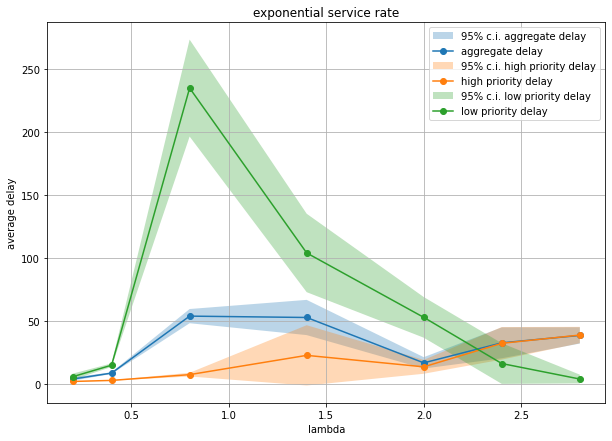

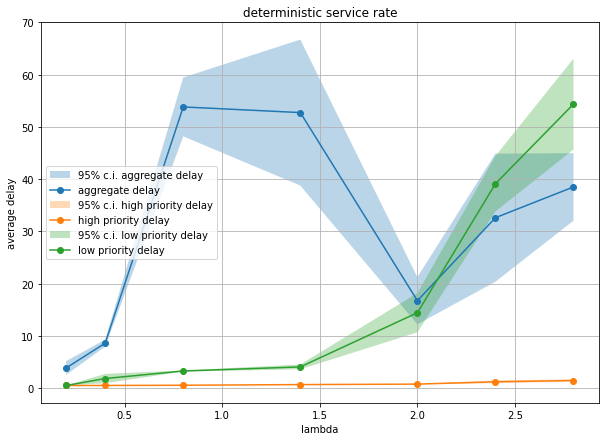

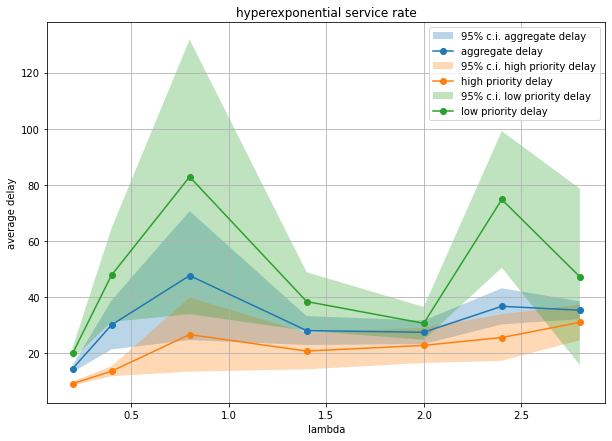

In [10]:
plot(exp_df, exp_df_h, exp_df_l, "exponential")
plot(det_df, det_df_h, det_df_l, "deterministic")
plot(hyper_df, hyper_df_h, hyper_df_l, "hyperexponential")